<a href="https://colab.research.google.com/github/StanleyLiangYork/2023_journal_club_CNN4N/blob/main/GAN_mode_collapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Tensorflow", tf.__version__)

Tensorflow 2.12.0


In [3]:
class GAN():
    def __init__(self, generator, discriminator):
        # discriminator
        self.D = discriminator
        self.G = generator

        self.bce = tf.keras.losses.BinaryCrossentropy()
        self.d_loss = {}
        self.g_loss = {}
        self.accuracy = {}
        self.g_gradients = []

    def discriminator_loss(self, pred_fake, pred_real):
        real_loss = self.bce(tf.ones_like(pred_real), pred_real)
        fake_loss = self.bce(tf.zeros_like(pred_fake), pred_fake)

        d_loss = 0.5*(real_loss + fake_loss)
        return d_loss

    def generator_loss(self, pred_fake):
        g_loss = self.bce(tf.ones_like(pred_fake), pred_fake)
        return g_loss

    def train_step(self, g_input, real_input):

        with tf.GradientTape() as g_tape,\
             tf.GradientTape() as d_tape:
            # Feed forward
            fake_input = self.G(g_input)

            pred_fake = self.D(fake_input)
            pred_real = self.D(real_input)

            # Calculate losses
            d_loss = self.discriminator_loss(pred_fake, pred_real)
            g_loss = self.generator_loss(pred_fake)

            # Accuracy
            fake_accuracy = tf.math.reduce_mean(binary_accuracy(tf.zeros_like(pred_fake), pred_fake))
            real_accuracy = tf.math.reduce_mean(binary_accuracy(tf.ones_like(pred_real), pred_real))

            # backprop gradients
            gradient_g = g_tape.gradient(g_loss, self.G.trainable_variables)
            gradient_d = d_tape.gradient(d_loss, self.D.trainable_variables)

            gradient_g_l1_norm = [tf.norm(gradient).numpy() for gradient in gradient_g]
            self.g_gradients.append(gradient_g_l1_norm)
            # update weights
            self.G_optimizer.apply_gradients(zip(gradient_g, self.G.trainable_variables))
            self.D_optimizer.apply_gradients(zip(gradient_d, self.D.trainable_variables))


        return g_loss, d_loss, fake_accuracy, real_accuracy

    def train(self, data_generator, z_generator,g_optimizer, d_optimizer, steps, interval=100):
        self.D_optimizer = d_optimizer
        self.G_optimizer = g_optimizer
        val_g_input = next(z_generator)
        for i in range(steps):
            g_input = next(z_generator)
            real_input = next(data_generator)

            g_loss, d_loss, fake_accuracy, real_accuracy = self.train_step(g_input, real_input)
            self.d_loss[i] = d_loss.numpy()
            self.g_loss[i] = g_loss.numpy()
            self.accuracy[i] = 0.5*(fake_accuracy.numpy() + real_accuracy.numpy())
            # print the information every 100 steps
            if i%interval == 0:
                msg = "Step {}: d_loss {:.4f} g_loss {:.4f} Accuracy. real : {:.3f} fake : {:.3f}".format(i, d_loss, g_loss, real_accuracy, fake_accuracy)
                print(msg)

                fake_images = self.G(val_g_input)
                self.plot_images(fake_images)


Here we define a mixture of two Gaussian distribution, one look round and the other looks elliptical.

In [4]:
def multimodal_normal(batch_size):
    while True:
        mean1 = [0, 0]
        cov1 = [[1, 0],
                [0, 1]]

        mean2 = [5, 5]
        cov2 = [[0.2, -2],
                [-2, 5]]

        x = []
        y = []
        means = [mean1, mean2]
        covs = [cov1, cov2]
        for _ in range(batch_size):
            i = np.random.randint(0,2)
            x1, y1 = np.random.multivariate_normal(means[i], covs[i], 1).T
            x.append(x1)
            y.append(y1)


        samples = np.stack((x,y), axis=1)

        yield samples

(-5.0, 10.0)

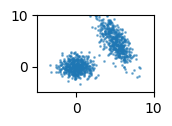

In [5]:
samples_gen = multimodal_normal(1000)
samples = next(samples_gen)
f, ax = plt.subplots(1, 1, figsize=(1*1.5, 1*1))

ax.scatter(samples[:,0], samples[:,1], s=1, alpha=0.5)
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)

Step 0: d_loss 0.7385 g_loss 0.6873 Accuracy. real : 0.307 fake : 0.250
(50000, 2)


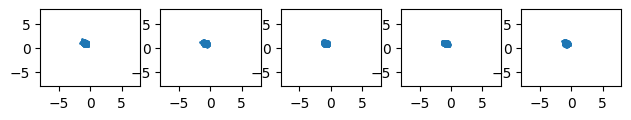

Step 1: d_loss 0.6641 g_loss 0.6126 Accuracy. real : 1.000 fake : 0.000
(50000, 2)


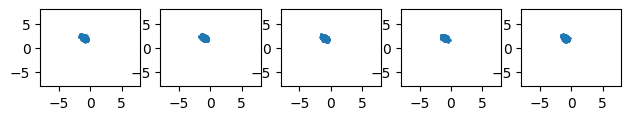

Step 2: d_loss 0.6413 g_loss 0.6011 Accuracy. real : 0.966 fake : 0.000
(50000, 2)


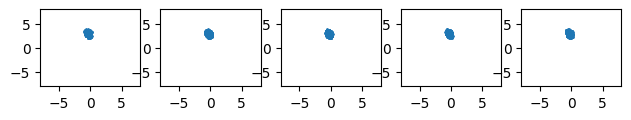

Step 3: d_loss 0.6351 g_loss 0.5979 Accuracy. real : 0.888 fake : 0.000
(50000, 2)


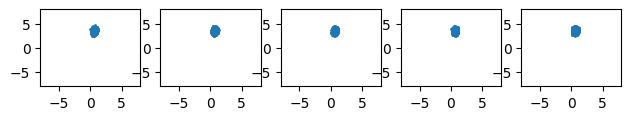

Step 4: d_loss 0.6520 g_loss 0.5729 Accuracy. real : 0.865 fake : 0.000
(50000, 2)


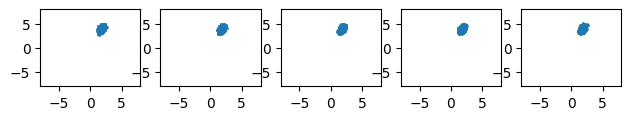

Step 5: d_loss 0.6743 g_loss 0.5578 Accuracy. real : 0.853 fake : 0.000
(50000, 2)


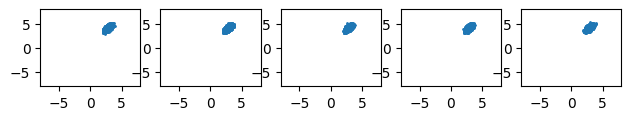

Step 6: d_loss 0.6801 g_loss 0.5836 Accuracy. real : 0.831 fake : 0.000
(50000, 2)


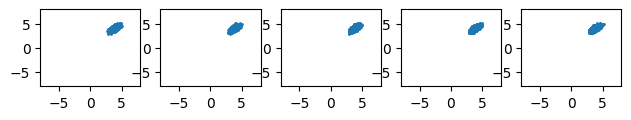

Step 7: d_loss 0.6843 g_loss 0.6178 Accuracy. real : 0.718 fake : 0.000
(50000, 2)


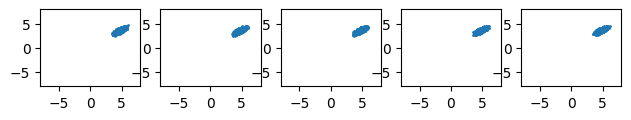

Step 8: d_loss 0.7065 g_loss 0.6171 Accuracy. real : 0.570 fake : 0.000
(50000, 2)


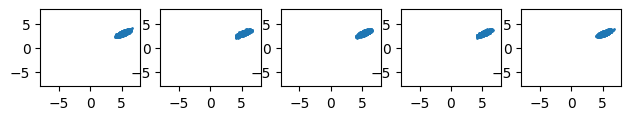

Step 9: d_loss 0.6952 g_loss 0.6770 Accuracy. real : 0.443 fake : 0.080
(50000, 2)


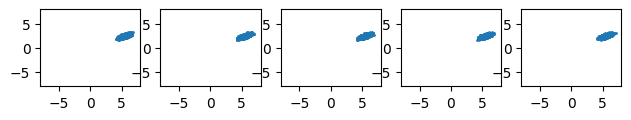

Step 10: d_loss 0.6983 g_loss 0.7160 Accuracy. real : 0.380 fake : 0.859
(50000, 2)


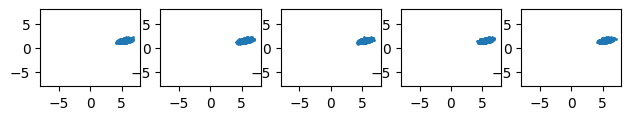

Step 11: d_loss 0.7113 g_loss 0.7033 Accuracy. real : 0.346 fake : 0.682
(50000, 2)


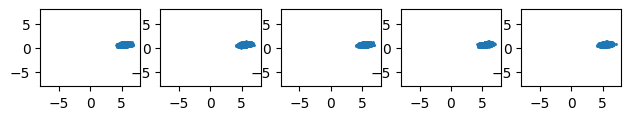

Step 12: d_loss 0.7234 g_loss 0.6757 Accuracy. real : 0.328 fake : 0.242
(50000, 2)


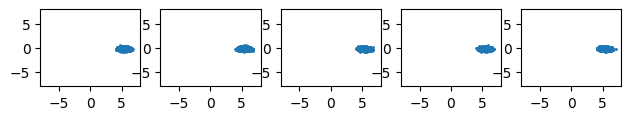

Step 13: d_loss 0.7067 g_loss 0.6937 Accuracy. real : 0.308 fake : 0.517
(50000, 2)


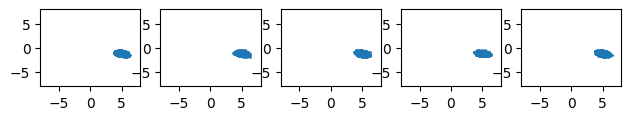

Step 14: d_loss 0.6791 g_loss 0.7302 Accuracy. real : 0.306 fake : 0.851
(50000, 2)


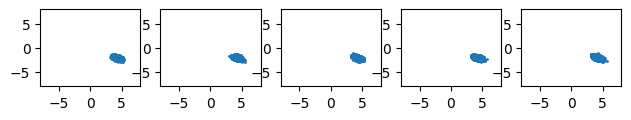

Step 15: d_loss 0.6677 g_loss 0.7214 Accuracy. real : 0.505 fake : 0.779
(50000, 2)


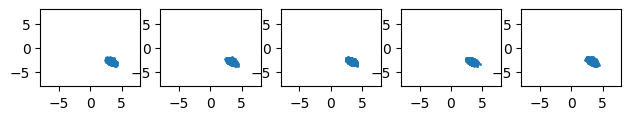

Step 16: d_loss 0.6828 g_loss 0.6532 Accuracy. real : 0.630 fake : 0.181
(50000, 2)


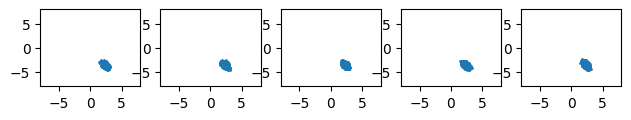

Step 17: d_loss 0.7636 g_loss 0.5022 Accuracy. real : 0.722 fake : 0.000
(50000, 2)


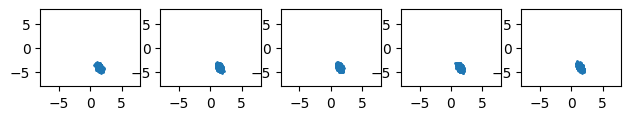

Step 18: d_loss 0.7807 g_loss 0.4652 Accuracy. real : 0.764 fake : 0.000
(50000, 2)


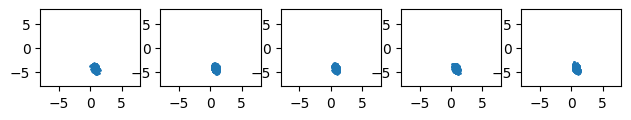

Step 19: d_loss 0.7126 g_loss 0.5389 Accuracy. real : 0.782 fake : 0.000
(50000, 2)


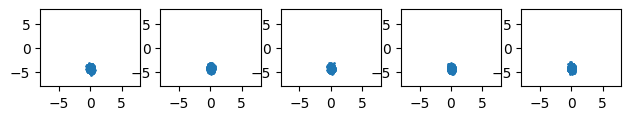

In [6]:
class VanillaGan(GAN):  # Vanilla means basic, simple, original model
    def __init__(self, z_dim, input_shape):

        discriminator = self.Discriminator(input_shape)
        generator = self.Generator(z_dim)

        GAN.__init__(self, generator, discriminator)

    def Discriminator(self, input_shape):
        model = tf.keras.Sequential()
        model.add(layers.Input(shape=input_shape))
        model.add(layers.Dense(200, activation='relu'))
        model.add(layers.Dense(50, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        return model

    def Generator(self, z_dim):
        model = tf.keras.Sequential()
        model.add(layers.Input(shape=[z_dim]))
        model.add(layers.Dense(200, activation='relu'))
        model.add(layers.Dense(50, activation='relu'))
        model.add(layers.Dense(2))
        return model

    def plot_images(self, images):
        grid_row = 1
        grid_col = 5
        f, ax = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1))
        print(images.shape)
        for col in range(grid_col):
            ax[col].scatter(images[col*10000:(col+1)*10000,0],
                          images[col*10000:(col+1)*10000,1], s=1)
            ax[col].set_xlim(-8, 8)
            ax[col].set_ylim(-8, 8)
            #axarr[col].axis('off')
        plt.show()

z_dim = 100
image_shape = (2)
batch_size = 50000

def z_generator(batch_size, z_dim):
    while True:
         yield tf.random.uniform((batch_size, z_dim))

z_gen = z_generator(batch_size, z_dim)

vanilla_gan = VanillaGan(z_dim, image_shape)
vanilla_gan.train(multimodal_normal(batch_size), z_gen, RMSprop(1e-3), RMSprop(1e-3), 20, 1)
# in the end, the generator produce an identical data point that is always accepted by the discriminator as real, so the generator cannot learn anymore